In [ ]:
import requests
import time

import pandas as pd
from datetime import datetime

import os
import logging
import io

logging.basicConfig(filename='logs.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

from io import StringIO
import boto3
import  matplotlib.pyplot as plt


from dotenv import dotenv_values, find_dotenv
config = dotenv_values(find_dotenv(".env"))

from functools import partial

from tqdm import tqdm

pd.options.display.max_columns = 100

### Подключение к s3

In [ ]:
session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id = config['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key = config['AWS_SECRET_ACCESS_KEY']
)

### Функция для парсинга

In [ ]:
def collect_moex_candles(stock_data, s3, api_url, s3_bucket, s3_path, attr='candles'):
    """
    Собирает данные о дневных котировках (цены закрытия и пр.) за период 2008-2024
    и сохраняет результат в S3 в формате CSV.

    :param stock_data: DataFrame (или иной объект) со списком тикеров в поле 'secid'
    :param s3: клиент S3 (boto3.client), настроенный под ваше хранилище
    :api_url: шаблон строки в который надо подставить ticker и start
    :s3_bucket: бакет s3
    :s3_path: путь папке на s3 для сохранения файла
    """
    for ticker in tqdm(stock_data['secid']):
        logger.info('Collecting data for ticker: %s', ticker)

        all_rows = []
        start = 0
        while True:
            url = api_url(ticker=ticker, start=start)
            logger.info('Requesting URL: %s', url)
            try:
                resp = requests.get(url, timeout=30)
                resp.raise_for_status()
                j = resp.json()
            except requests.exceptions.RequestException as e:
                logger.error("Request failed for %s: %s", ticker, e)
                break

            candles_data = j.get(attr, {}).get('data', [])
            columns = j.get(attr, {}).get('columns', [])

            if not candles_data:
                logger.info('No more data for %s. Processed until start=%s', ticker, start)
                break

            for row in candles_data:
                row_dict = {col: row[i] for i, col in enumerate(columns)}
                all_rows.append(row_dict)

            logger.info("Received %d rows for %s at start=%d", len(candles_data), ticker, start)
            start += len(candles_data)

            time.sleep(0.3)

        frame = pd.DataFrame(all_rows)
        logger.info("Total extracted for %s: %d rows", ticker, len(frame))

        csv_data = frame.to_csv(index=False).encode('utf-8')
        try:
            s3.put_object(
                Bucket=s3_bucket,
                Key=f'{s3_path}/{ticker}.csv',
                Body=csv_data
            )
            logger.info("Successful upload to S3: %s.csv", ticker)
        except Exception as e:
            logger.error("S3 upload failed for %s: %s", ticker, e)

        time.sleep(1)

### Облигации

In [ ]:
# метаданные
all_ticket_meta = requests.get('https://iss.moex.com/iss/engines/stock/markets/bonds/boards/TQOB/securities.json').json()

columns = all_ticket_meta['securities']['columns']
data = all_ticket_meta['securities']['data']

df_raw = pd.DataFrame(data, columns=columns)
df_meta_bonds = df_raw.drop(columns=['CALLOPTIONDATE', 'PUTOPTIONDATE','DATEYIELDFROMISSUER', 'OFFERDATE', 'SECTORID', 'REMARKS'], axis=1)
df_meta_bonds.columns = [x.lower() for x in df_meta_bonds.columns]

df_meta_bonds

,secid,boardid,shortname,prevwaprice,yieldatprevwaprice,couponvalue,nextcoupon,accruedint,prevprice,lotsize,facevalue,boardname,status,matdate,decimals,couponperiod,issuesize,prevlegalcloseprice,prevdate,secname,marketcode,instrid,minstep,faceunit,buybackprice,buybackdate,isin,latname,regnumber,currencyid,issuesizeplaced,listlevel,sectype,couponpercent,settledate,lotvalue,facevalueonsettledate
0,SU25085RMFS0,TQOB,ОФЗ 25085,NaN,0.00,31.91,2025-09-24,14.38,NaN,1,1000.00,Т+: Гособлигации - безадрес.,A,2025-09-24,4,182,15000000,NaN,2025-06-11,ОФЗ-ПД 25085 24/09/2025,FNDT,GOFZ,0.001,SUR,None,0000-00-00,RU000A103BQ2,OFZ-PD 25085,25085RMFS,SUR,15000000.0,1,3,6.40,2025-06-16,1000.00,1000.00
1,SU26207RMFS9,TQOB,ОФЗ 26207,89.725,16.04,40.64,2025-08-06,29.25,89.873,1,1000.00,Т+: Гособлигации - безадрес.,A,2027-02-03,4,182,370299980,89.640,2025-06-11,ОФЗ-ПД 26207 03/02/27,FNDT,GOFZ,0.001,SUR,None,0000-00-00,RU000A0JS3W6,OFZ-PD 26207,26207RMFS,SUR,370299980.0,1,3,8.15,2025-06-16,1000.00,1000.00
2,SU26212RMFS9,TQOB,ОФЗ 26212,83.955,15.22,35.15,2025-07-23,28.00,84.037,1,1000.00,Т+: Гособлигации - безадрес.,A,2028-01-19,4,182,356981514,83.900,2025-06-11,ОФЗ-ПД 26212 19/01/28,FNDT,GOFZ,0.001,SUR,None,0000-00-00,RU000A0JTK38,OFZ-PD 26212,26212RMFS,SUR,348053926.0,1,3,7.05,2025-06-16,1000.00,1000.00
3,SU26218RMFS6,TQOB,ОФЗ 26218,75.941,14.98,42.38,2025-09-24,19.09,75.931,1,1000.00,Т+: Гособлигации - безадрес.,A,2031-09-17,4,182,347608211,75.850,2025-06-11,ОФЗ-ПД 26218 17/09/31,FNDT,GOFZ,0.001,SUR,None,0000-00-00,RU000A0JVW48,OFZ-PD 26218,26218RMFS,SUR,261115356.0,1,3,8.50,2025-06-16,1000.00,1000.00
4,SU26219RMFS4,TQOB,ОФЗ 26219,90.922,16.59,38.64,2025-09-17,18.90,90.992,1,1000.00,Т+: Гособлигации - безадрес.,A,2026-09-16,4,182,362076549,90.789,2025-06-11,ОФЗ-ПД 26219 16/09/26,FNDT,GOFZ,0.001,SUR,None,0000-00-00,RU000A0JWM07,OFZ-PD 26219,26219RMFS,SUR,362076549.0,1,3,7.75,2025-06-16,1000.00,1000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,SU46023RMFS6,TQOB,ОФЗ 46023,93.106,15.69,4.07,2025-07-24,3.22,93.366,1,100.00,Т+: Гособлигации - безадрес.,A,2026-07-23,4,182,295000000,93.402,2025-06-11,ОФЗ-АД 46023 23/07/26,FNDT,GOFZ,0.001,SUR,None,0000-00-00,RU000A0JRTL6,OFZ-AD 46023,46023RMFS,SUR,295000000.0,1,3,8.16,2025-06-16,100.00,100.00
53,SU52002RMFS1,TQOB,ОФЗ 52002,81.054,11.25,20.63,2025-08-06,14.80,81.124,1,1648.59,Т+: Гособлигации - безадрес.,A,2028-02-02,4,182,250000000,81.147,2025-06-11,ОФЗ-ИН 52002 02/02/28,FNDT,GOFZ,0.001,SUR,None,0000-00-00,RU000A0ZYZ26,OFZ-IN 52002,52002RMFS,SUR,250000000.0,1,3,2.50,2025-06-16,1648.59,1649.64
54,SU52003RMFS9,TQOB,ОФЗ 52003,71.918,9.82,18.76,2025-07-23,14.90,71.899,1,1498.87,Т+: Гособлигации - безадрес.,A,2030-07-17,4,182,218186911,71.892,2025-06-11,ОФЗ-ИН 52003,FNDT,GOFZ,0.001,SUR,None,0000-00-00,RU000A102069,OFZ-IN 52003,52003RMFS,SUR,218186911.0,1,3,2.50,2025-06-16,1498.87,1499.83
55,SU52004RMFS7,TQOB,ОФЗ 52004,69.412,8.73,17.63,2025-09-24,7.92,69.157,1,1409.13,Т+: Гособлигации - безадрес.,A,2032-03-17,4,182,250000000,69.498,2025-06-11,ОФЗ-ИН 52004 17/03/32,FNDT,GOFZ,0.001,SUR,None,0000-00-00,RU000A103MX5,OFZ-IN 52004,52004RMFS,SUR,250000000.0,1,3,2.50,2025-06-16,1409.13,1410.03


In [ ]:
csv_data = df_meta_bonds.to_csv(index=False).encode('utf-8')
s3.put_object(
    Bucket='finrisk-lake',
    Key=f'meta_store/gos_bond_metadata.csv',
    Body=csv_data
)

{'ResponseMetadata': {'RequestId': 'cba368822d563ddf',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'nginx',
   'date': 'Fri, 13 Jun 2025 11:09:35 GMT',
   'content-type': 'application/octet-stream',
   'transfer-encoding': 'chunked',
   'connection': 'keep-alive',
   'keep-alive': 'timeout=60',
   'etag': '"98aadcddeeb2931e4f4dde281b64c58f"',
   'x-amz-request-id': 'cba368822d563ddf'},
  'RetryAttempts': 0},
 'ETag': '"98aadcddeeb2931e4f4dde281b64c58f"'}

In [ ]:
# свечи по бумагам
template = (
    'https://iss.moex.com/iss/engines/{engine}/'
    'markets/{market}/boards/{board}/securities/{ticker}/candles.json'
    '?from={start_date}&till={end_date}&interval={interval}&start={start}'
)
engine='stock'
market='bonds'
board='TQOB'
start_date='2021-01-01'
end_date='2025-01-01'
interval='24'

api_url = partial(
    template.format,
    engine=engine,
    market=market,
    board=board,
    start_date=start_date,
    end_date=end_date,
    interval=interval,
)

collect_moex_candles(df_meta_bonds, s3, api_url, 'finrisk-lake', '/gos_bonds')

100%|██████████| 57/57 [02:02<00:00,  2.15s/it]


### Индексы

In [ ]:
# свечи по бумагам
template = (
    'https://iss.moex.com/iss/engines/{engine}/'
    'markets/{market}/boards/{board}/securities/{ticker}/candles.json'
    '?from={start_date}&till={end_date}&interval={interval}&start={start}'
)
engine='stock'
market='index'
board='SNDX'
start_date='2021-01-01'
end_date='2025-01-01'
interval='24'

api_url = partial(
    template.format,
    engine=engine,
    market=market,
    board=board,
    start_date=start_date,
    end_date=end_date,
    interval=interval,
)

df_index = pd.DataFrame({"secid":["IMOEX", "RTSI"]})
collect_moex_candles(df_index, s3, api_url, 'finrisk-lake', '/base_active')

100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


### Валюты

In [ ]:
# биржевые
template = (
    'https://iss.moex.com/iss/statistics/engines/{engine}/'
    'markets/{market}/securities/{ticker}.json'
    '?from={start_date}&till={end_date}&interval={interval}&start={start}'
)
engine='futures'
market='indicativerates'
start_date='2021-01-01'
end_date='2025-01-01'
interval='24'

api_url = partial(
    template.format,
    engine=engine,
    market=market,
    board=board,
    start_date=start_date,
    end_date=end_date,
    interval=interval,
)

df_curr = pd.DataFrame({"secid":["USD/RUB", "EUR/RUB"]})
collect_moex_candles(df_curr, s3, api_url, 'finrisk-lake', '/base_active', 'securities')

100%|██████████| 2/2 [00:16<00:00,  8.06s/it]


In [ ]:
# ЦБ
usd = pd.read_excel('./parsers/usd_cb.xlsx')
eur = pd.read_excel('./parsers/euro_cb.xlsx')

In [ ]:
csv_data = usd.to_csv(index=False).encode('utf-8')
s3.put_object(
    Bucket='finrisk-lake',
    Key='/base_active/usd_cb.csv',
    Body=csv_data
)

csv_data = eur.to_csv(index=False).encode('utf-8')
s3.put_object(
    Bucket='finrisk-lake',
    Key='/base_active/euro_cb.csv',
    Body=csv_data
)

{'ResponseMetadata': {'RequestId': '07b42d5809d590d4',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'nginx',
   'date': 'Fri, 13 Jun 2025 13:21:32 GMT',
   'content-type': 'application/octet-stream',
   'transfer-encoding': 'chunked',
   'connection': 'keep-alive',
   'keep-alive': 'timeout=60',
   'etag': '"a29c8d5e3bb6ae232f984af01c031265"',
   'x-amz-request-id': '07b42d5809d590d4'},
  'RetryAttempts': 0},
 'ETag': '"a29c8d5e3bb6ae232f984af01c031265"'}

### Кривая

In [ ]:
# свечи по бумагам
template = (
    'https://iss.moex.com/iss/apps/bondization/zcyc_range_calculator.json'
    '?from={start_date}&till={end_date}&periods={periods}&iss.dp={iss_dp}&iss.df={iss_df}'
)

periods='0.25,0.5,0.75,1,2,3,5,7,10,15,20,30'
iss_dp='comma'
iss_df='%25d.%25m.%25Y'

api_url = partial(
    template.format,
    iss_dp=iss_dp,
    iss_df=iss_df,
    periods=periods,
)

from datetime import datetime
from dateutil.relativedelta import relativedelta

start_date = datetime(2021, 1, 1)
end_date = datetime(2025, 1, 1)
df_data = []

current_date = start_date
while current_date < end_date:
    next_date = current_date + relativedelta(months=1)

    url = api_url(start_date=current_date.date(), end_date=next_date.date())
    js = requests.get(url).json()

    col = js['zcyc']['columns']
    data = js['zcyc']['data']

    df_data.extend(data)
    current_date = next_date

df = pd.DataFrame(df_data, columns=col).drop_duplicates()
df

,tradedate,tradetime,period_0.25,period_0.5,period_0.75,period_1.0,period_2.0,period_3.0,period_5.0,period_7.0,period_10.0,period_15.0,period_20.0,period_30.0
0,2021-01-04,18:39:52,4.03,4.09,4.14,4.20,4.50,4.87,5.44,5.84,6.25,6.65,6.87,7.08
1,2021-01-05,18:39:43,3.98,4.04,4.11,4.18,4.48,4.82,5.38,5.80,6.22,6.62,6.84,7.06
2,2021-01-06,18:39:57,3.85,3.95,4.04,4.11,4.42,4.79,5.40,5.83,6.24,6.62,6.82,7.03
3,2021-01-08,18:39:53,3.78,3.88,3.99,4.08,4.46,4.84,5.45,5.85,6.24,6.59,6.76,6.92
4,2021-01-11,18:39:53,4.17,4.19,4.22,4.26,4.56,4.92,5.52,5.93,6.34,6.70,6.89,7.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,2024-12-25,18:39:56,18.33,18.33,18.30,18.24,17.88,17.44,16.58,15.91,15.21,14.52,14.15,13.80
1029,2024-12-26,18:39:54,17.97,17.99,17.98,17.96,17.70,17.33,16.57,15.95,15.28,14.62,14.26,13.94
1030,2024-12-27,18:39:59,17.49,17.59,17.64,17.67,17.56,17.29,16.65,16.08,15.43,14.75,14.36,13.99
1031,2024-12-28,18:39:58,18.55,18.58,18.57,18.53,18.15,17.67,16.83,16.21,15.57,14.92,14.55,14.20


In [ ]:
csv_data = df.to_csv(index=False).encode('utf-8')
s3.put_object(
    Bucket='finrisk-lake',
    Key='/curves/zcyc.csv',
    Body=csv_data
)

{'ResponseMetadata': {'RequestId': 'f124946c1f969174',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'nginx',
   'date': 'Fri, 13 Jun 2025 13:13:40 GMT',
   'content-type': 'application/octet-stream',
   'transfer-encoding': 'chunked',
   'connection': 'keep-alive',
   'keep-alive': 'timeout=60',
   'etag': '"b8d4e9e55eb1380befd57b3b373ac6d8"',
   'x-amz-request-id': 'f124946c1f969174'},
  'RetryAttempts': 0},
 'ETag': '"b8d4e9e55eb1380befd57b3b373ac6d8"'}

___

### Цены на Нефть

In [8]:
import pandas as pd
oil_price_draft = pd.read_csv('BZ_210101_250101.csv', sep=';')
oil_price_draft.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,BZ,D,210104,0,51.50,53.33,50.56,50.67,267461
1,BZ,D,210105,0,50.95,53.90,50.70,53.57,296062
2,BZ,D,210106,0,53.52,54.73,53.02,54.15,231283
3,BZ,D,210107,0,54.13,54.90,53.94,54.52,144086
4,BZ,D,210108,0,54.56,56.36,54.34,56.36,192380


In [10]:
# Преобразование столбца DATE в datetime
oil_price_draft['DATE'] = pd.to_datetime(oil_price_draft['<DATE>'], format='%y%m%d')
oil_price = oil_price_draft[['DATE', '<CLOSE>']]
oil_price = oil_price.rename(columns={'<CLOSE>': 'CLOSE'})
oil_price

,DATE,CLOSE
0,2021-01-04,50.67
1,2021-01-05,53.57
2,2021-01-06,54.15
3,2021-01-07,54.52
4,2021-01-08,56.36
...,...,...
1037,2024-12-26,73.29
1038,2024-12-27,74.00
1039,2024-12-30,74.13
1040,2024-12-31,74.83


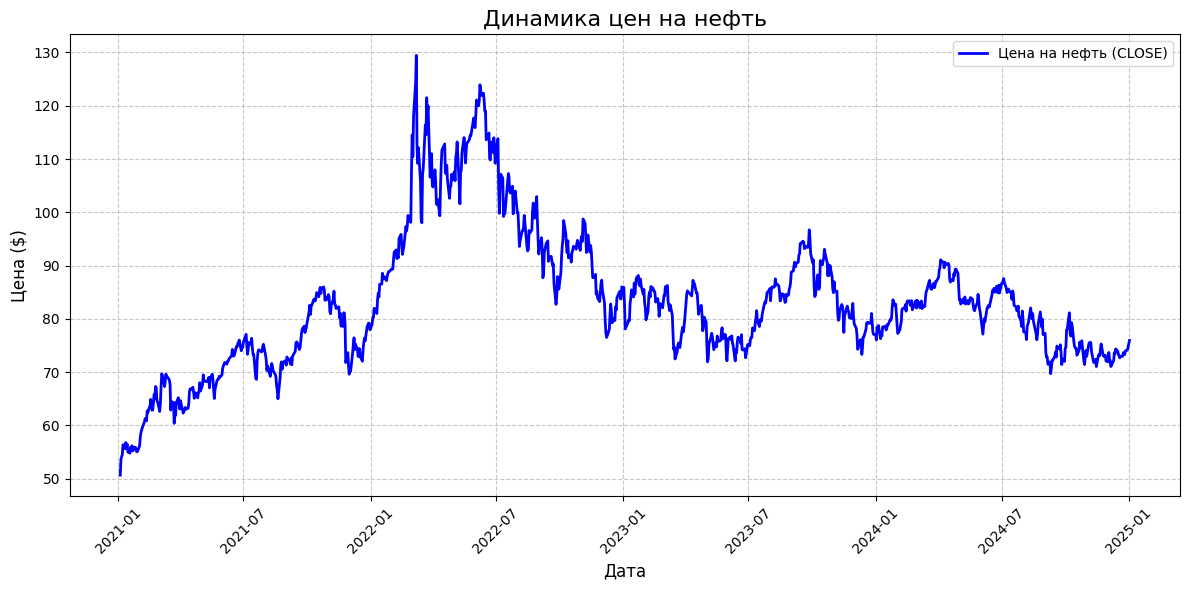

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(oil_price['DATE'], oil_price['CLOSE'], color='blue', linewidth=2, label='Цена на нефть (CLOSE)')

plt.title('Динамика цен на нефть', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
oil_price.to_csv('oil_price.csv', index=False)
print("Файл oil_price.csv успешно сохранён!")

Файл oil_price.csv успешно сохранён!
